## Notebook for learning CVs from diffusion maps for metadynamics

Author: Antonia Mey <antonia.mey@ed.ac.uk>   
Content: Cobbled together from bits by Zofia and Muneeb Sultan

In [2]:
%pylab inline
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as image
from pyemma import msm
from scipy.interpolate import griddata
from matplotlib.pyplot import cm
import metadynamics

Populating the interactive namespace from numpy and matplotlib


/home/ppxasjsm/miniconda3/envs/cvlearn/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'cosh', 'tanh', 'bar', 'copy', 'radians', 'degrees', 'tan', 'dot', 'sqrt', 'bytes', 'cos', 'sin', 'sum', 'byte', 'griddata', 'sinh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import simtk.openmm as mm
platforms = [ mm.Platform.getPlatform(index).getName() for index in range(mm.Platform.getNumPlatforms()) ]
print (platforms)

['Reference', 'CPU', 'CUDA', 'OpenCL']


In [4]:
def _compute_torsion(coordinates, i, j, k, l):
    """
    Compute torsion angle defined by four atoms.

    ARGUMENTS

    coordinates (simtk.unit.Quantity wrapping numpy natoms x 3) - atomic coordinates
    i, j, k, l - four atoms defining torsion angle

    NOTES

    Algorithm of Swope and Ferguson [1] is used.

    [1] Swope WC and Ferguson DM. Alternative expressions for energies and forces due to angle bending and torsional energy.
    J. Comput. Chem. 13:585, 1992.

    """
    # Swope and Ferguson, Eq. 26
    rij = (coordinates[i] - coordinates[j]) / nanometers
    rkj = (coordinates[k] - coordinates[j]) / nanometers
    rlk = (coordinates[l] - coordinates[k]) / nanometers
    rjk = (coordinates[j] - coordinates[k]) / nanometers # added

    # Swope and Ferguson, Eq. 27
    t = np.cross(rij, rkj)
    u = np.cross(rjk, rlk) # fixed because this didn't seem to match diagram in equation in paper

    # Swope and Ferguson, Eq. 28
    t_norm = np.sqrt(numpy.dot(t, t))
    u_norm = np.sqrt(numpy.dot(u, u))

    cos_theta = np.dot(t, u) / (t_norm * u_norm)

    theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)).value_in_unit(nanometer**-5))
    theta = math.degrees(theta)*degree
    return theta


In [5]:
#Free energy surface reference adp do not use in a quantitative fashion
def adp_reference():
    centers = np.load('control_data/centers.npy')
    tau = 6
    dtrajs_long = list(np.load('control_data/dtrajs_long.npz')['arr_0'])
    msm_nrev = msm.estimate_markov_model(dtrajs_long, tau, count_mode='sample')
    lcc = msm_nrev.active_set
    pi = msm_nrev.stationary_distribution
    kB=8.314472471220217*1e-3  # kJ/(K*mol)
    T=300.0                    # K
    beta=1.0/(kB*T)            # mol/kJ
    A = -1.0/beta*np.log(pi)
    A -= A.min()
    centers_lcc = centers[lcc, :]
    nx = 60
    x = np.linspace(-180.0, 180.0, nx)
    ny = 60
    y = np.linspace(-180.0, 180.0, ny)
    X, Y = np.meshgrid(x, y)
    AXY = griddata(centers_lcc, A, (X, Y), method='cubic')
    return (X,Y,AXY)

## Running a standard MD simulations computing torsions

In [6]:
# Bunch of useful simulation parameters
steps = 50
iterations = 1000
beta = 1.0/(300.0*0.0083144621)

In [7]:
## standard simulation
phi = [1, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
pdb_name = '/home/ppxasjsm/Projects/git/openmm/wrappers/python/tests/systems/alanine-dipeptide-explicit.pdb'
pdb = PDBFile('/home/ppxasjsm/Projects/git/openmm/wrappers/python/tests/systems/alanine-dipeptide-explicit.pdb')
        
forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)
simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName('CUDA'))
simulation.context.setPositions(pdb.positions)

potential_list = []
torsion_list = []
simulation.reporters.append(DCDReporter('/home/ppxasjsm/Projects/People/Zofia/adp_openmm/trajectory.dcd', steps, append=True))
for i in range(iterations):
    simulation.step(steps)

    state = simulation.context.getState(getEnergy=True, enforcePeriodicBox = True)
    positions = simulation.context.getState(getPositions=True).getPositions()
    coordinates = positions.value_in_unit(nanometer)
    dihedral = np.zeros(2)

    dihedral[0] = _compute_torsion(coordinates, phi[0],phi[1],phi[2],phi[3]).value_in_unit(degree)
    dihedral[1] = _compute_torsion(coordinates, psi[0],psi[1],psi[2],psi[3]).value_in_unit(degree)
    torsion_list.append(dihedral)
    potential_list.append(state.getPotentialEnergy().value_in_unit(kilojoule/mole))



In [8]:
#Converting generated lists to numpy arrays
torsion_list = np.array(torsion_list)
potential_list = np.array(potential_list)

In [9]:
# Plotting the reference as contours
X,Y,AXY = adp_reference()
plt.contour(X,Y, AXY, cmap= cm.gray)
plt.colorbar()
# Adding directory data as scatter points
plt.scatter(torsion_list[:,0],torsion_list[:,1])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')

FileNotFoundError: [Errno 2] No such file or directory: 'control_data/centers.npy'

## RMSD from MDtraj

In [14]:
import mdtraj as md

/home/ppxasjsm/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [15]:
def myRMSD():
    traj = md.load('trajectory.dcd', top=pdb_name).remove_solvent()
    rmsd = md.rmsd(traj,traj,frame=0)
    return rmsd

## RMSD and using diffusion maps to get first eigenvector. 

In [16]:
# download from https://pypi.python.org/pypi/rmsd/1.2.5
import rmsd


def myRMSDmetric(arr1, arr2):
    """
    This function is built under the assumption that the space dimension is 3!!!
    Requirement from sklearn radius_neighbors_graph: The callable should take two arrays as input and return one value indicating the distance between them.
     Input: One row from reshaped XYZ trajectory as number of steps times nDOF
     Inside: Reshape to XYZ format and apply rmsd as r=rmsd(X[i], X[j])
     Output: rmsd distance
    """
    
    nParticles = len(arr1) / 3;
    assert (nParticles == int(nParticles))

    X1 = arr1.reshape(int(nParticles), 3 )
    X2 = arr2.reshape(int(nParticles), 3 )

    X1 = X1 -  rmsd.centroid(X1)
    X2 = X2 -  rmsd.centroid(X2)

    return rmsd.kabsch_rmsd(X1, X2)



ModuleNotFoundError: No module named 'rmsd'

In [17]:
traj = md.load('trajectory.dcd', top=pdb_name).remove_solvent().xyz
Xresh=traj.reshape(traj.shape[0], traj.shape[1]*traj.shape[2])

In [18]:
import pydiffmap.diffusion_map as dfm_est

ModuleNotFoundError: No module named 'pydiffmap'

In [ ]:
## WARNING: This takes a long time also for a small number of frames! 
## Not sure how to give weight to this either!
mydmap = dfm_est.DiffusionMap(n_evecs=5, epsilon=0.1, alpha = 0.5, k=500, metric=myRMSDmetric)
mydmap.fit_transform(Xresh)
evec = np.asarray(mydmap.evecs[:,0])

## Just copied some plotting functionality. Not really used

In [19]:
def plot_free_energy(xxx, beta):

    valsor, edgesor = np.histogram(xxx, bins=50, normed=True)
    edgesor=0.5*(edgesor[1:]+edgesor[:-1])

    plt.plot(edgesor, -beta * np.log(valsor), '-r')
    plt.show()

In [20]:
def plot(x, color=None, title=None):

    cbar = plt.scatter(x[:,0], x[:,1], s=10, cmap=ev_cmap)
    plt.colorbar(cbar)

    plt.xlabel('phi')
    plt.ylabel('psi')
    if title is not None:
        plt.title(title)
    plt.show()

In [21]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
     return mpl.colors.LinearSegmentedColormap(name, cm.revcmap(cmap._segmentdata))

rev_spectral = reverse_colourmap(cm.Spectral, name = 'mysp')
potential_cmap = cm.Greys
ev_cmap = rev_spectral

## Bog standard metadynamics simulation using phi and psi as CVs

[[1.59201073 1.85221463 2.09928618 ... 0.81548529 1.06249891 1.32545117]
 [1.23858718 1.43988898 1.63010289 ... 0.63367671 0.82649257 1.03145221]
 [0.92014606 1.06797861 1.20657633 ... 0.47103606 0.61469863 0.76698755]
 ...
 [2.60298787 3.01773412 3.40909518 ... 1.35397769 1.75337732 2.1762321 ]
 [2.30562864 2.67883584 3.03302419 ... 1.19099459 1.54609719 1.92337978]
 [1.95752918 2.2770963  2.58100054 ... 1.00594125 1.30857115 1.63069097]]
[[1.59202121 1.85224772 2.0993844  ... 0.81548552 1.06249979 1.32545429]
 [1.23859459 1.43991238 1.63017233 ... 0.63367687 0.82649319 1.03145442]
 [0.92015098 1.06799415 1.20662243 ... 0.47103617 0.61469904 0.76698901]
 ...
 [2.60300817 3.01779831 3.40928608 ... 1.35397813 1.753379   2.17623813]
 [2.30564598 2.67889064 3.03318704 ... 1.19099496 1.54609863 1.92338494]
 [1.95754309 2.27714025 2.58113104 ... 1.00594155 1.30857231 1.63069511]]
[[1.59275138 1.85409972 2.1038087  ... 0.81551667 1.06259451 1.32572535]
 [1.239147   1.44131564 1.63353013 ... 

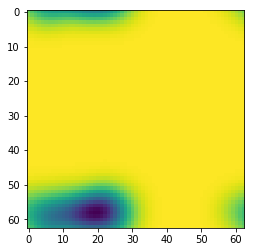

In [14]:
# Create a System for alanine dipeptide in water.

pdb = PDBFile('/home/ppxasjsm/Projects/git/openmm/wrappers/python/tests/systems/alanine-dipeptide-explicit.pdb')
        
forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, constraints=HBonds)

# Define collective variables for phi and psi.
cv1 = CustomTorsionForce('theta')
cv1.addTorsion(1, 6, 8, 14)
phi = metadynamics.BiasVariable(cv1, -np.pi, np.pi, 0.5, True)
cv2 = CustomTorsionForce('theta')
cv2.addTorsion(6, 8, 14, 16)
psi = metadynamics.BiasVariable(cv2, -np.pi, np.pi, 0.5, True)
# Set up the simulation.

meta = metadynamics.Metadynamics(system, [phi, psi], 300.0*kelvin, 1000.0, 1.0*kilojoules_per_mole, 100)
integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)
simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName('CUDA'))
simulation.context.setPositions(pdb.positions)

# Run the simulation and plot the free energy landscape.

for i in range(5):
    meta.step(simulation, 1000)
    print (meta._bias)
plt.imshow(meta.getFreeEnergy())
plt.show()

In [11]:
np.shape(meta._bias)

(63, 63)

## Diffusion map

In [15]:
import pydiffmap.diffusion_map as dfm_est

ModuleNotFoundError: No module named 'pydiffmap'